In [1]:
# standard lib
import sqlite3
import io
import time

# data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# utils
from tqdm.notebook import tqdm

# chess
import chess
import chess
import chess.pgn
import chess.engine

# my custom libs
from gameeval import landscapeeval, gameeval
from mmaformatter import save_as_mma

In [2]:
con = sqlite3.connect('data.db')
cur = con.cursor()

# Schema

In [3]:
# see all the tables
res = cur.execute("SELECT name FROM sqlite_schema WHERE type='table';")
res.fetchall()

[('games',), ('sqlite_sequence',)]

In [4]:
# see all the column names in the games table
res = cur.execute('SELECT * FROM games')
list(map(lambda x: x[0], res.description))

['id',
 'Event',
 'Site',
 'Round',
 'White',
 'Black',
 'Result',
 'UTCDate',
 'UTCTime',
 'UTCDateTime',
 'WhiteElo',
 'BlackElo',
 'WhiteRatingDiff',
 'BlackRatingDiff',
 'WhiteTitle',
 'BlackTitle',
 'ECO',
 'Variant',
 'Opening',
 'TimeControl',
 'Termination',
 'Moves']

# Query examples

Select for ELO

In [5]:
query = "SELECT * FROM games WHERE BlackElo > 1980;"
res = cur.execute(query)
print(res.fetchone())

(78, 'Rated Blitz game', 'https://lichess.org/5ug0gm2j', '', 'joecasatro', '?', '0-1', '2012.12.31', '23:41:40', '2012-12-31 23:41:40', 1081, '?', '', '', '', '', 'B54', '', 'Sicilian Defense', '300+3', 'Normal', '1. e4 c5 2. Nf3 d6 3. d4 Na6 4. Bxa6 bxa6 5. dxc5 Bb7 6. cxd6 exd6 7. Nc3 Nf6 8. e5 Ng4 9. exd6 Bxd6 10. h3 Qe7+ 11. Be3 Nxe3 12. fxe3 Qxe3+ 13. Ne2 Bg3+ 14. Kf1 Qf2# 0-1')


Select for result, and use COUNT to count number of entries instead of fetching the data itself

In [6]:
query = "SELECT COUNT(*) FROM games WHERE Result = '1-0';"
res = cur.execute(query)
print(res.fetchone())

(62129,)


Select for date range (more options: https://stackoverflow.com/questions/2309227/sqlite-select-with-condition-on-date)

In [7]:
query = "SELECT * FROM games WHERE UTCDateTime BETWEEN date('2012-12-31') AND date('2013-01-05');"
res = cur.execute(query)
print(res.fetchone())

(1, 'Rated Classical game', 'https://lichess.org/j1dkb5dw', '', 'BFG9k', 'mamalak', '1-0', '2012.12.31', '23:01:03', '2012-12-31 23:01:03', 1639, 1403, '+5', '-8', '', '', 'C00', '', 'French Defense: Normal Variation', '600+8', 'Normal', '1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6 gxh6 6. Be2 Qg5 7. Bg4 h5 8. Nf3 Qg6 9. Nh4 Qg5 10. Bxh5 Qxh4 11. Qf3 Kd8 12. Qxf7 Nc6 13. Qe8# 1-0')


Query with multiple things, e.g. combining usernames and ELO in various ways

In [8]:
query = "SELECT COUNT(*) FROM games WHERE White = 'BFG9k' AND BlackElo > 1600;"
res = cur.execute(query)
print(res.fetchone())

(58,)


In [9]:
query = "SELECT COUNT(*) FROM games WHERE (White = 'adepa' AND BlackElo > 1600) OR (Black = 'adepa' AND WhiteElo > 1600);"
res = cur.execute(query)
print(res.fetchone())

(10,)


# Read data into dataframe for further analysis

In [10]:
# query = "SELECT * FROM games WHERE UTCDateTime BETWEEN date('2012-12-31') AND date('2013-01-05');"
# query = "SELECT * FROM games"
# query = "SELECT * FROM games WHERE (White = 'adepa' AND BlackElo > 1600) OR (Black = 'adepa' AND WhiteElo > 1600);"
query = "SELECT * FROM games WHERE WhiteElo > 2100 AND BlackElo > 2100"
df = pd.read_sql_query(query, con)

In [11]:
df[["White", "Black", "WhiteElo", "BlackElo"]]

,White,Black,WhiteElo,BlackElo
0,ObviousEngineUser,Ghost_Lombardi,2114,2144
1,piligrim,dek,2130,2101
2,dek,piligrim,2114,2117
3,piligrim,dek,2117,2114
4,celeron17,StefanK,2126,2112
...,...,...,...,...
68,chert843,piligrim,2145,2122
69,RaptoR-Bee,xiaoqiao,2180,2123
70,chert843,Mish,2129,2217
71,Mish,chert843,2214,2131


In [12]:
# how many rows did we get?
df.shape[0]

73

## Cleaning and type conversion

In [13]:
# Replace ? with NaN
# (There were some ? in the BlackElo column and maybe others)
df = df.replace(to_replace="?", value=np.nan)

In [14]:
# See the dtypes. Might want to convert some of these to more useful things.
df.dtypes

id                  int64
Event              object
Site               object
Round              object
White              object
Black              object
Result             object
UTCDate            object
UTCTime            object
UTCDateTime        object
WhiteElo            int64
BlackElo            int64
WhiteRatingDiff    object
BlackRatingDiff    object
WhiteTitle         object
BlackTitle         object
ECO                object
Variant            object
Opening            object
TimeControl        object
Termination        object
Moves              object
dtype: object

In [15]:
# Convert Elo to float (can't do int since there are some NaNs, but float will work fine)
df["WhiteElo"] = df["WhiteElo"].astype(np.float64)
df["BlackElo"] = df["BlackElo"].astype(np.float64)

In [16]:
# Convert DateTime column to datetime type
df["UTCDateTime"] = pd.to_datetime(df["UTCDateTime"])

## Descriptive statistics etc.

In [17]:
df.describe()

,id,UTCDateTime,WhiteElo,BlackElo
count,73.000000,73,73.000000,73.000000
mean,59592.767123,2013-01-16 11:55:57.000000256,2147.767123,2147.561644
min,2970.000000,2013-01-01 20:53:59,2102.000000,2101.000000
25%,35904.000000,2013-01-10 07:54:06,2117.000000,2117.000000
50%,63943.000000,2013-01-17 19:02:09,2135.000000,2133.000000
75%,82031.000000,2013-01-22 09:36:04,2164.000000,2156.000000
max,120740.000000,2013-01-31 20:31:13,2276.000000,2278.000000
std,30558.277573,NaN,42.092003,42.773300


In [18]:
df["Result"].value_counts()

Result
1-0        39
0-1        27
1/2-1/2     7
Name: count, dtype: int64

# Move evaluation

In [19]:
num = 0
pgn = io.StringIO(df["Moves"][num])
game = chess.pgn.read_game(pgn)

In [20]:
df["Moves"][num]

'1. d4 e6 2. c4 Nf6 3. Nc3 Bb4 4. Qc2 b6 5. a3 Bxc3+ 6. Qxc3 Ne4 7. Qc2 f5 8. e3 Bb7 9. f3 Qh4+ 10. g3 Nxg3 11. Qf2 f4 12. e4 Qh6 13. hxg3 Qxh1 14. Bxf4 Qh5 15. O-O-O d6 16. Ne2 O-O 17. g4 Qf7 18. Bg2 Nd7 19. Qh4 e5 20. Rh1 g6 21. Bh6 Rfe8 22. d5 c6 23. Ng3 cxd5 24. cxd5 Nf8 25. Qg5 Qe7 26. Qe3 Rac8+ 27. Kb1 Ba6 28. f4 Qc7 29. fxe5 Qc2+ 30. Ka1 Bc4 31. Bxf8 Rxf8 32. Qh6 Rf2 33. Qxh7+ Kf8 34. Qh8+ Ke7 35. Rh7+ Rf7 36. Qf6+ Ke8 37. Qxf7+ 1-0'

In [21]:
# Make evaluations of position using stockfish
# Path to stockfish engine
engine = chess.engine.SimpleEngine.popen_uci("/usr/local/Cellar/stockfish/17/bin/stockfish")

In [22]:
centipawns, wdls = gameeval(game, engine, depth=10)

Text(0, 0.5, 'Centipawns')

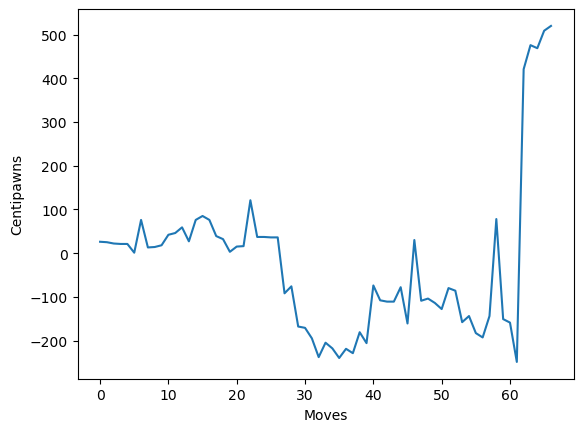

In [23]:
fig, ax = plt.subplots()
ax.plot(centipawns[centipawns < 5000]) # exclude things close to mate so we can see the dynamics of the game better
ax.set_xlabel("Moves")
ax.set_ylabel("Centipawns")

## Compare engine parameters
Look at different values for the depth to see how much time they take and how much improvement you get.

In [21]:
# Make board
results_cp = []
results_wdl = []
depths = [5, 10, 15, 20]
times = []
for depth in depths:
    print(depth)
    start = time.time()
    cps, wdls = gameeval(game, engine, depth=depth)
    end = time.time()
    results_cp.append(cps)
    results_wdl.append(wdls)
    times.append(end-start)

5
10
15
20


Text(0, 0.5, 'Time (s)')

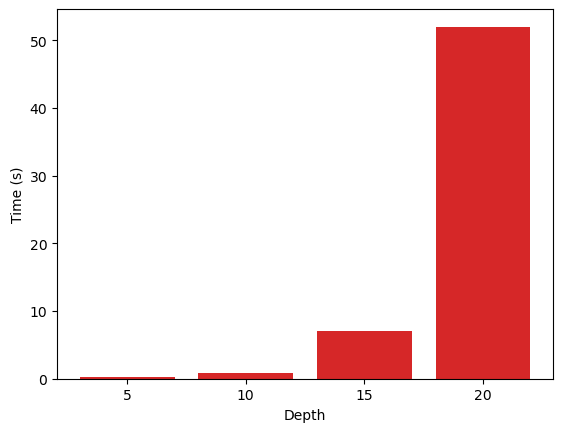

In [23]:
fig, ax = plt.subplots()
for i, depth in enumerate(depths):
    ax.bar([str(d) for d in depths], times)
# ax.legend()
ax.set_xlabel("Depth")
ax.set_ylabel("Time (s)")

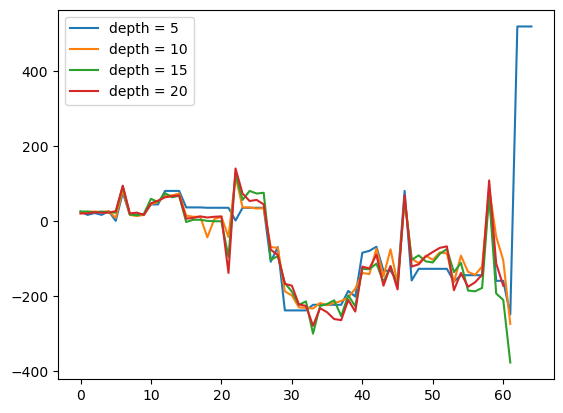

In [27]:
fig, ax = plt.subplots()
for i, depth in enumerate(depths):
    ax.plot(results_cp[i][np.abs(results_cp[i]) < 5000], label=f"depth = {depth}")
ax.legend()

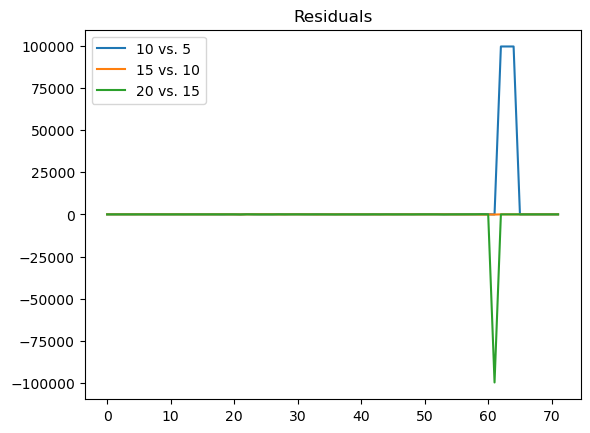

In [28]:
fig, ax = plt.subplots()
for i in range(1, len(results_cp)):
    ax.plot(results_cp[i] - results_cp[i-1], label=f"{depths[i]} vs. {depths[i-1]}")
ax.set_title("Residuals")
ax.legend()
# ax.set_xlim(0, 60)

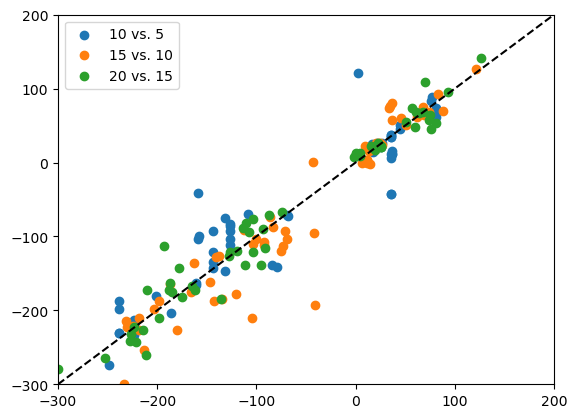

In [29]:
fig, ax = plt.subplots()
for i in range(1, len(results_cp)):
    ax.scatter(results_cp[i-1], results_cp[i], label=f"{depths[i-1]} vs. {depths[i]}")
ax.plot(range(-300, 200), range(-300, 200), linestyle="--", color="k")
ax.set_xlim(-300, 200)
ax.set_ylim(-300, 200)
ax.legend()

# Generate a landscape of possible moves
Iterate through a game and build a small tree of options for each position

In [24]:
# pick a random game from our dataframe
num = 2
pgn = io.StringIO(df["Moves"][num])
game = chess.pgn.read_game(pgn)
game_length = len(list(game.mainline_moves()))
game_length

87

In [25]:
# info about this game
dict(df.iloc[num,:])

{'id': np.int64(10416),
 'Event': 'Rated Blitz game',
 'Site': 'https://lichess.org/cfol8seb',
 'Round': '',
 'White': 'dek',
 'Black': 'piligrim',
 'Result': '1/2-1/2',
 'UTCDate': '2013.01.03',
 'UTCTime': '19:39:25',
 'UTCDateTime': Timestamp('2013-01-03 19:39:25'),
 'WhiteElo': np.float64(2114.0),
 'BlackElo': np.float64(2117.0),
 'WhiteRatingDiff': '+0',
 'BlackRatingDiff': '+0',
 'WhiteTitle': '',
 'BlackTitle': '',
 'ECO': 'C55',
 'Variant': '',
 'Opening': 'Italian Game: Two Knights Defense',
 'TimeControl': '180+0',
 'Termination': 'Normal',
 'Moves': '1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Qe2 Be7 5. c3 d6 6. O-O O-O 7. d3 Bg4 8. Nbd2 Na5 9. Bb5 c6 10. Ba4 b5 11. Bc2 c5 12. a4 a6 13. Rd1 Nc6 14. Nf1 b4 15. Ne3 Bh5 16. Nf5 g6 17. Ng3 Bg4 18. h3 Bxf3 19. Qxf3 d5 20. Bg5 d4 21. h4 Nd7 22. Bh6 dxc3 23. bxc3 bxc3 24. Bxf8 Bxf8 25. Ne2 Nd4 26. Nxd4 cxd4 27. Bb3 Qe7 28. h5 Nc5 29. Bd5 Rb8 30. hxg6 hxg6 31. Qg4 Kg7 32. f4 Rb2 33. f5 Qf6 34. Qg3 g5 35. Ra2 Qh6 36. Rxb2 cxb2 37. Qf2 Nxa4 38

In [26]:
# OR create a dummy game
# https://www.chess.com/forum/view/game-showcase/the-shortest-game-in-history---guiness-record
# pgn = """e4 f6
# d4 g5
# Qh5#
# """
# pgn = io.StringIO(pgn)
# game = chess.pgn.read_game(pgn)
# game_length = len(list(game.mainline_moves()))
# game_length

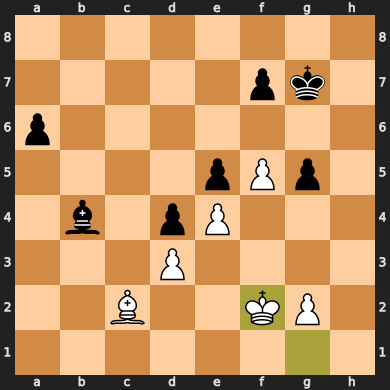

In [27]:
# final board state of the game we're looking at
game.end().board()

In [28]:
# Make evaluations of position using stockfish
# Path to stockfish engine
engine = chess.engine.SimpleEngine.popen_uci("/usr/local/Cellar/stockfish/17/bin/stockfish")

In [29]:
# run landscape eval
landscape = landscapeeval(game, engine, k=3, d=2, depth=10)

In [30]:
len(landscape)

86

Plot how the centipawn scores in the trees change over time during the game

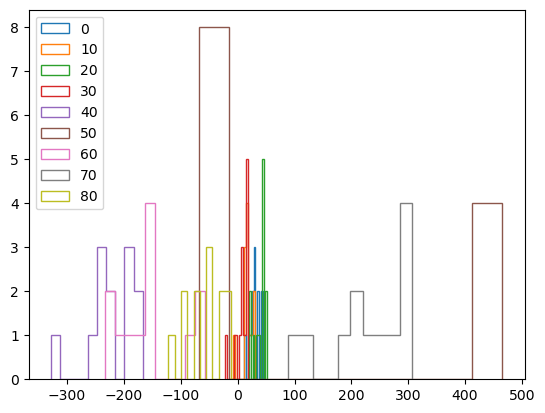

In [31]:
fig, ax = plt.subplots()
for n, vals in enumerate([[j[-2] for j in i[0]] for i in landscape]): # j[-2] are the cp scores
    if n % 10 == 0:
        vals = pd.Series(vals).dropna()
        # ax.hist(vals[vals < 5000], histtype="step", label=n)
        ax.hist(vals, histtype="step", label=n)
ax.legend()

# Evaluate multiple games

In [33]:
# Make evaluations of position using stockfish
# Path to stockfish engine
engine = chess.engine.SimpleEngine.popen_uci("/usr/local/Cellar/stockfish/17/bin/stockfish")

In [34]:
cp_evals = []
wdl_evals = []
landscapes = []
k = 3
d = 2
depth = 10
for moves in tqdm(df["Moves"]):
    pgn = io.StringIO(moves)
    # print(moves)
    game = chess.pgn.read_game(pgn)
    # game_length = len(list(game.mainline_moves()))
    cps, wdls = gameeval(game, engine, depth=depth)
    landscape = landscapeeval(game, engine, k=k, d=d, depth=depth)
    cp_evals.append(cps)
    wdl_evals.append(wdls)
    landscapes.append(landscape)

  0%|          | 0/73 [00:00<?, ?it/s]

In [36]:
# df["Centipawns"] = [json.dumps(c.tolist()) for c in cp_evals]
# df["WDLs"] = [json.dumps(w.tolist()) for w in wdl_evals]
# df["Landscapes"] = [json.dumps(l) for l in landscapes]

In [35]:
df.to_csv("../Elo_above_2100_k=3_d=2_depth=10.csv")

In [36]:
save_as_mma([c.tolist() for c in cp_evals], "../Centipawns_Elo_above_2100_k=3_d=2_depth=10.mx")
save_as_mma([w.tolist() for w in wdl_evals], "../WDLs_Elo_above_2100_k=3_d=2_depth=10.mx")
save_as_mma(landscapes, "../Landscapes_Elo_above_2100_k=3_d=2_depth=10.mx")